In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')
df = pd.read_csv("gdrive/My Drive/BigDataBowl2021/plyrsWithTargets.csv",
                 index_col=0)
df.head(3)

Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,gameId,playId,gameClock,defendersInTheBox,passResult,targetNflId,time,x,y,s,a,dis,event,epa,frameId,nflId,displayName,position,route,team,homeTeamAbbr,visitorTeamAbbr,targetedReceiver,team_name,qbX,qbY,distanceFromQB,angleToQB
1,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:14,28.27,26.663333,0.00,0.01,0.02,None,0.261827,1,310,Matt Ryan,QB,NaN,away,PHI,ATL,0.0,ATL,28.27,26.663333,0.000000,0.000000
2,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:14,28.65,9.173333,0.02,0.03,0.01,None,0.261827,1,2495454,Julio Jones,WR,HITCH,away,PHI,ATL,1.0,ATL,28.27,26.663333,17.494128,-88.755379
3,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:14,29.22,17.183333,0.00,0.00,0.00,None,0.261827,1,2533040,Mohamed Sanu,WR,HITCH,away,PHI,ATL,0.0,ATL,28.27,26.663333,9.527481,-84.277469


In [3]:
openness_df = pd.read_pickle("gdrive/My Drive/BigDataBowl2021/all_weeks.pickle")
openness_df.head()

,Unnamed: 0,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,eligible_receiver,is_defense,polygon,openness
0,490,2018-09-07T01:07:18.099Z,96.43,26.78,0.84,2.05,0.08,356.40,333.39,pass_forward,310.0,Matt Ryan,2.0,QB,36,away,2018090600,75,left,NaN,False,False,None,NaN
1,491,2018-09-07T01:07:18.099Z,84.82,38.33,5.53,4.30,0.54,295.34,318.58,pass_forward,79848.0,Malcolm Jenkins,27.0,SS,36,home,2018090600,75,left,NaN,False,True,"POLYGON ((84.64338696128041 35.50709230853111,...",NaN
2,492,2018-09-07T01:07:18.099Z,80.69,44.91,3.11,6.67,0.34,155.11,297.88,pass_forward,2495454.0,Julio Jones,11.0,WR,36,away,2018090600,75,left,HITCH,True,False,"POLYGON ((81.52261524240826 42.20689958416092,...",0.847541
3,493,2018-09-07T01:07:18.099Z,86.02,18.64,3.52,0.69,0.35,28.19,216.15,pass_forward,2495613.0,Corey Graham,24.0,FS,36,home,2018090600,75,left,NaN,False,True,"POLYGON ((88.8147532851782 19.07514833676076, ...",NaN
4,494,2018-09-07T01:07:18.099Z,82.65,34.56,6.35,1.21,0.64,262.06,272.78,pass_forward,2533040.0,Mohamed Sanu,12.0,WR,36,away,2018090600,75,left,HITCH,True,False,"POLYGON ((84.55064402112779 32.4653515080207, ...",0.799221


In [4]:
# slim down openness ,df then merge
openness_df = openness_df[['gameId', 'playId', 'frameId', 'nflId', 'displayName', 'openness']]
openness_df.dropna(inplace=True)
openness_df.nflId = openness_df.nflId.astype(int)
openness_df.head()

,gameId,playId,frameId,nflId,displayName,openness
2,2018090600,75,36,2495454,Julio Jones,0.847541
4,2018090600,75,36,2533040,Mohamed Sanu,0.799221
6,2018090600,75,36,2543583,Devonta Freeman,1
10,2018090600,75,36,2555415,Austin Hooper,0.538622
12,2018090600,75,36,2559033,Ricky Ortiz,0.906936


In [5]:
df = df.merge(openness_df,
              how='left',
              on=['gameId', 'playId', 'frameId', 'nflId', 'displayName'])
df.head()

,gameId,playId,gameClock,defendersInTheBox,passResult,targetNflId,time,x,y,s,a,dis,event,epa,frameId,nflId,displayName,position,route,team,homeTeamAbbr,visitorTeamAbbr,targetedReceiver,team_name,qbX,qbY,distanceFromQB,angleToQB,openness
0,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:14,28.27,26.663333,0.00,0.01,0.02,None,0.261827,1,310,Matt Ryan,QB,NaN,away,PHI,ATL,0.0,ATL,28.27,26.663333,0.000000,0.000000,NaN
1,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:14,28.65,9.173333,0.02,0.03,0.01,None,0.261827,1,2495454,Julio Jones,WR,HITCH,away,PHI,ATL,1.0,ATL,28.27,26.663333,17.494128,-88.755379,NaN
2,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:14,29.22,17.183333,0.00,0.00,0.00,None,0.261827,1,2533040,Mohamed Sanu,WR,HITCH,away,PHI,ATL,0.0,ATL,28.27,26.663333,9.527481,-84.277469,NaN
3,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:14,21.75,26.703333,0.01,0.01,0.00,None,0.261827,1,2543583,Devonta Freeman,RB,NaN,away,PHI,ATL,0.0,ATL,28.27,26.663333,6.520123,-0.351504,NaN
4,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:14,28.71,31.503333,0.01,0.02,0.01,None,0.261827,1,2555415,Austin Hooper,TE,OUT,away,PHI,ATL,0.0,ATL,28.27,26.663333,4.859959,84.805601,NaN


In [6]:
# df = df[df.position != 'QB']

In [7]:
dummies = pd.get_dummies(df.position, prefix='Position')
df = pd.concat([df.reset_index(drop=True), dummies.reset_index(drop=True)], axis=1)

In [8]:
# filter_df = df[(df.targetedReceiver == 1) & ((df.event == 'pass_outcome_caught') | (df.event == 'pass_outcome_incomplete') |
#                                  (df.event == 'pass_outcome_interception') | (df.event == 'pass_outcome_touchdown'))]
# filter_df.head()

In [9]:
# filter_df['roundAngle'] = round(filter_df.angleToQB, 0)
# filter_df.head()

In [10]:
# round_angs = filter_df.groupby('roundAngle').agg({'epa':'mean'})
# round_angs.reset_index(inplace=True)
# round_angs.head()

In [11]:
# from bokeh.plotting import figure, output_file, show, output_notebook
# from bokeh.palettes import magma 
  
# # file to save the model  
# # output_file("gfg.html")
# output_notebook() 
       
# # instantiating the figure object  
# graph = figure(title = "Relationship Between Receiver Angle to QB and EPA")  
  
# # name of the x-axis  
# graph.xaxis.axis_label = "Angle to QB"
       
# # name of the y-axis  
# graph.yaxis.axis_label = "Expected Points Addded"

# size = 10
  
# # plotting the graph  
# graph.line(round_angs['roundAngle'],
#               round_angs['epa'])  
       
# # displaying the model  
# show(graph)

**Now implement xgboost for target probability**

In [12]:
df['event'].unique()

array(['None', 'ball_snap', 'pass_forward', 'pass_arrived',
       'pass_outcome_caught', 'out_of_bounds', 'pass_outcome_incomplete',
       'first_contact', 'tackle', 'man_in_motion', 'play_action',
       'qb_sack', 'fumble', 'fumble_offense_recovered', 'handoff',
       'pass_tipped', 'pass_outcome_interception', 'qb_strip_sack',
       'pass_shovel', 'line_set', 'pass_outcome_touchdown',
       'fumble_defense_recovered', 'qb_spike', 'touchdown',
       'penalty_flag', 'shift', 'run', 'touchback', 'penalty_accepted',
       'field_goal_blocked', 'run_pass_option', 'punt_fake',
       'snap_direct', 'pass_lateral', 'lateral', 'huddle_start_offense',
       'huddle_break_offense', 'field_goal_fake', 'timeout_home',
       'safety', 'field_goal_play'], dtype=object)

When thinking about this target probability model... the only instantaneous moment we need to evaluate would be the moment in which the pass is arriving OR the moment the pass is released (ie when the QB chose to make the throw), right?

Bc the split second where that event occurs is far more important than the first 3 steps off the line (not saying those aren't important to getting there) but we only need to know what happening exactly when the target is being earned.

Account for distance from other receivers on same play, this adds more context to the moment.

FE: 

- need to get distance to nearest defender(s). Is there a mathematical function I can use to weight one really close defender and one far away to account for possible double coverages? Or, just make it 2 columns.

- should do something with player orientation and direction of motion given we evened out the field, relative to the QB and in general

- angular direction i.e. speed in x and y
- Number of eligible receivers on field for that play

In [13]:
filter_df = df[df.event == 'pass_forward']
filter_df.head()

,gameId,playId,gameClock,defendersInTheBox,passResult,targetNflId,time,x,y,s,a,dis,event,epa,frameId,nflId,displayName,position,route,team,homeTeamAbbr,visitorTeamAbbr,targetedReceiver,team_name,qbX,qbY,distanceFromQB,angleToQB,openness,Position_FB,Position_HB,Position_QB,Position_RB,Position_TE,Position_WR
210,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:18,23.57,26.553333,0.84,2.05,0.08,pass_forward,0.261827,36,310,Matt Ryan,QB,NaN,away,PHI,ATL,0.0,ATL,23.57,26.553333,0.000000,0.000000,NaN,0,0,1,0,0,0
211,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:18,39.31,8.423333,3.11,6.67,0.34,pass_forward,0.261827,36,2495454,Julio Jones,WR,HITCH,away,PHI,ATL,1.0,ATL,23.57,26.553333,24.009259,-49.036342,0.847541,0,0,0,0,0,1
212,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:18,37.35,18.773333,6.35,1.21,0.64,pass_forward,0.261827,36,2533040,Mohamed Sanu,WR,HITCH,away,PHI,ATL,0.0,ATL,23.57,26.553333,15.824563,-29.448491,0.799221,0,0,0,0,0,1
213,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:18,26.19,26.033333,3.92,3.23,0.39,pass_forward,0.261827,36,2543583,Devonta Freeman,RB,NaN,away,PHI,ATL,0.0,ATL,23.57,26.553333,2.671105,-11.225802,1,0,0,0,1,0,0
214,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:18,36.80,31.973333,6.21,2.68,0.62,pass_forward,0.261827,36,2555415,Austin Hooper,TE,OUT,away,PHI,ATL,0.0,ATL,23.57,26.553333,14.297178,22.277693,0.538622,0,0,0,0,1,0


In [14]:
filter_df = filter_df[filter_df.targetedReceiver >= 0]

In [15]:
filter_df.targetedReceiver = filter_df.targetedReceiver.astype(int)

In [16]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, plot_precision_recall_curve, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

In [17]:
class RFClassifier():
    
    # points [2]
    def randomForestClassifier(self, x_train, y_train, x_test=None):
        # TODO: Create a RandomForestClassifier and train it. Set Random state to 614.
        # args: pandas dataframe, pandas dataframe, pandas series
        # return: RandomForestClassifier object, numpy array, numpy array
        # -------------------------------
        rf_clf = RandomForestClassifier(random_state=614)
        rf_clf.fit(x_train, y_train)
        y_predict_train = rf_clf.predict_proba(x_train)
        y_predict_train = np.array(y_predict_train)
        y_predict_test = None
        if type(x_test) != type(None):
          y_predict_test = rf_clf.predict_proba(x_test)
          y_predict_test = np.array(y_predict_test)
        # -------------------------------
        return rf_clf,y_predict_train, y_predict_test
    
    # points [1]
    def rfTrainAccuracy(self,y_train,y_predict_train):
        # TODO: Return accuracy on the training set using the accuracy_score method.
        # args: pandas series, numpy array
        # return: float
        # -------------------------------
        y_predict_train = np.rint(y_predict_train)
        train_accuracy = accuracy_score(y_train, y_predict_train)
        # -------------------------------
        return train_accuracy
    
    # points [1]
    def rfTestAccuracy(self,y_test,y_predict_test):
        # TODO: Return accuracy on the test set using the accuracy_score method.
        # args: pandas series, numpy array
        # return: float
        # -------------------------------
        y_predict_test = np.rint(y_predict_test)
        test_accuracy = accuracy_score(y_test, y_predict_test)
        # -------------------------------
        return test_accuracy
    
# Q3.3.1 Feature Importance
    
    # points [1]
    def rfFeatureImportance(self,rf_clf):
        # TODO: Determine the feature importance as evaluated by the Random Forest Classifier.
        # args: RandomForestClassifier object
        # return: float array
        # -------------------------------
        # ADD CODE HERE
        feature_importance = rf_clf.feature_importances_
        # std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
        #      axis=0)
        # indices = np.argsort(importances)[::-1]
        # -------------------------------
        return feature_importance
    
    # points [1]
    def sortedRFFeatureImportanceIndicies(self,rf_clf):
        # TODO: Sort them in the ascending order and return the feature numbers[0 to ...].
        #       Hint: There is a direct function available in sklearn to achieve this. Also checkout argsort() function in Python.
        # args: RandomForestClassifier object
        # return: int array
        # -------------------------------
        importances = rf_clf.feature_importances_

        sorted_indices = np.argsort(importances)[::-1]
        # -------------------------------
        return sorted_indices
    
# Q3.3.2 Hyper-parameter Tuning

    # points [2]
    def hyperParameterTuning(self,rf_clf,x_train,y_train):
        # TODO: Tune the hyper-parameters 'n_estimators' and 'max_depth'.
        # args: RandomForestClassifier object, pandas dataframe, pandas series
        # return: GridSearchCV object
        # 'n_estimators': [4, 16, 256]
        # 'max_depth': [2, 8, 16]
        # -------------------------------
        parameters = { 
            'n_estimators': [50, 100, 250, 500],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [4,5,6,7,8],
            'criterion' : ['gini', 'entropy']
            }
        gscv_rfc = GridSearchCV(rf_clf, parameters)
        gscv_rfc.fit(x_train, y_train)
        # -------------------------------
        return gscv_rfc
    
    # points [1]
    def bestParams(self,gscv_rfc):
        # TODO: Get the best params, using .best_params_
        # args:  GridSearchCV object
        # return: parameter dict
        # -------------------------------
        best_params = gscv_rfc.best_params_
        # -------------------------------
        return best_params
    
    # points [1]
    def bestScore(self,gscv_rfc):
        # TODO: Get the best score, using .best_score_.
        # args: GridSearchCV object
        # return: float
        # -------------------------------
        best_score = gscv_rfc.best_score_
        # -------------------------------
        return best_score

In [18]:
def trainSets(x_data,y_data):
  # Split 70% of the data into training and 30% into test sets. Call them x_train, x_test, y_train and y_test.
  # Use the train_test_split method in sklearn with the parameter 'shuffle' set to true and the 'random_state' set to 614.
  # args: pandas dataframe, pandas dataframe
  # return: pandas dataframe, pandas dataframe, pandas series, pandas series
  # -------------------------------
  x_train, x_test, y_train, y_test = train_test_split(
      x_data, y_data,
      test_size=0.3, train_size=.7,
      random_state=614, shuffle=True)
  # -------------------------------
  return x_train, x_test, y_train, y_test

Steps:

1. Get only predictor columns and response set up
2. Train model
3. Test model on entire (column-filtered) df ( issue of perfect prediction should be rectified because the predictions don't = 1, 0 in prior predictions )
4. 'Join' back on data needed to compute summary statistics


In [19]:
filter_df = filter_df[filter_df.position != 'QB']
filter_df.dropna(inplace=True)
filter_df.head()

,gameId,playId,gameClock,defendersInTheBox,passResult,targetNflId,time,x,y,s,a,dis,event,epa,frameId,nflId,displayName,position,route,team,homeTeamAbbr,visitorTeamAbbr,targetedReceiver,team_name,qbX,qbY,distanceFromQB,angleToQB,openness,Position_FB,Position_HB,Position_QB,Position_RB,Position_TE,Position_WR
211,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:18,39.31,8.423333,3.11,6.67,0.34,pass_forward,0.261827,36,2495454,Julio Jones,WR,HITCH,away,PHI,ATL,1,ATL,23.57,26.553333,24.009259,-49.036342,0.847541,0,0,0,0,0,1
212,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:18,37.35,18.773333,6.35,1.21,0.64,pass_forward,0.261827,36,2533040,Mohamed Sanu,WR,HITCH,away,PHI,ATL,0,ATL,23.57,26.553333,15.824563,-29.448491,0.799221,0,0,0,0,0,1
214,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:18,36.80,31.973333,6.21,2.68,0.62,pass_forward,0.261827,36,2555415,Austin Hooper,TE,OUT,away,PHI,ATL,0,ATL,23.57,26.553333,14.297178,22.277693,0.538622,0,0,0,0,1,0
215,2018090600,75,15:00:00,7.0,C,2495454.0,2018-09-07 01:07:18,30.38,34.943333,6.75,1.51,0.67,pass_forward,0.261827,36,2559033,Ricky Ortiz,FB,FLAT,away,PHI,ATL,0,ATL,23.57,26.553333,10.805934,50.934451,0.906936,1,0,0,0,0,0
535,2018090600,146,13:10:00,7.0,I,2560854.0,2018-09-07 01:09:12,64.06,27.053333,3.30,0.16,0.33,pass_forward,-0.372360,31,2543583,Devonta Freeman,RB,FLAT,away,PHI,ATL,0,ATL,66.12,23.613333,4.009638,-59.085277,1,0,0,0,1,0,0


In [20]:
filter_df = filter_df[(filter_df.position != 'FB') & (filter_df.position != 'HB') & (filter_df.position != 'RB')]

In [21]:
# first train then grab a test accuracy to report
# predictors = filter_df[['defendersInTheBox', 's', 'a', 'distanceFromQB', 'angleToQB', 'targetedReceiver',
#                         'Position_TE', 'Position_WR', 'openness']]
predictors = filter_df[['openness', 'targetedReceiver', 's', 'a', 'defendersInTheBox', 'distanceFromQB', 'angleToQB']]
response = np.array(predictors.targetedReceiver)
predictors.drop('targetedReceiver', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
len(predictors)

61916

In [23]:
split = trainSets(predictors, response)
x_train = split[0]
x_test = split[1]
y_train = split[2]
y_test = split[3]

# TEST WITH NO RUNNING BACKS AND LESS VARIABLES

In [24]:
rf = RFClassifier()
rf_model = rf.randomForestClassifier(x_train, y_train, x_test)

positive_preds = [x[1] for x in rf_model[1]]
round_pos_preds = np.rint(positive_preds)

print("Train Accuracy:")
print(rf.rfTrainAccuracy(y_train, round_pos_preds))

positive_preds = [x[1] for x in rf_model[2]]
round_pos_preds = np.rint(positive_preds)

print("Test Accuracy:")
print(rf.rfTestAccuracy(y_test, round_pos_preds))

print("Feature Importance:")
print(predictors.columns)
print(rf.rfFeatureImportance(rf_model[0]))

Train Accuracy:
0.9999769271590411
Test Accuracy:
0.7926783310901749
Feature Importance:
Index(['openness', 's', 'a', 'defendersInTheBox', 'distanceFromQB',
       'angleToQB'],
      dtype='object')
[0.17622478 0.18732343 0.18547678 0.04967572 0.21126904 0.19003025]


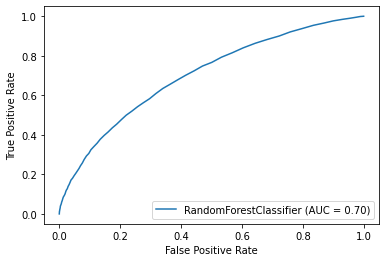

In [25]:
plot_roc_curve(rf_model[0], x_test, y_test)

[Text(0, 0, 'openness'),
 Text(0, 0, 's'),
 Text(0, 0, 'a'),
 Text(0, 0, 'defendersInTheBox'),
 Text(0, 0, 'distanceFromQB'),
 Text(0, 0, 'angleToQB')]

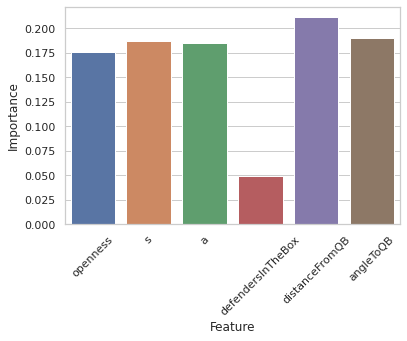

In [28]:
feat_imp = pd.DataFrame(predictors.columns, rf.rfFeatureImportance(rf_model[0])).reset_index()
feat_imp.columns = ['Importance', 'Feature']

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
g = sns.barplot(x="Feature", y="Importance", data=feat_imp)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

In [32]:
predictors = filter_df[['defendersInTheBox', 's', 'a', 'distanceFromQB', 'angleToQB', 'targetedReceiver',
                        'Position_FB', 'Position_HB', 'Position_RB', 'Position_TE', 'Position_WR', 'openness']]
predictors.dropna(inplace=True)
response = np.array(predictors.targetedReceiver)
predictors.reset_index(inplace=True)
predictors = predictors[['defendersInTheBox', 's', 'a', 'distanceFromQB', 'angleToQB',
                         'openness']]
display(predictors,
        response)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,defendersInTheBox,s,a,distanceFromQB,angleToQB,openness
0,7.0,3.11,6.67,24.009259,-49.036342,0.847541
1,7.0,6.35,1.21,15.824563,-29.448491,0.799221
2,7.0,6.21,2.68,14.297178,22.277693,0.538622
3,7.0,5.20,1.12,8.207667,16.491973,0.45752
4,7.0,7.01,0.21,13.852310,-62.436050,0.477303
...,...,...,...,...,...,...
61911,4.0,7.79,0.55,24.151135,-42.063053,0.52353
61912,6.0,1.25,1.95,16.603668,-21.295182,0.458735
61913,6.0,8.97,1.47,28.158878,-28.185006,0.275623
61914,6.0,6.16,4.42,22.203903,-19.112256,0.972019


array([1, 0, 0, ..., 1, 0, 0])

In [33]:
rf = RFClassifier()
rf_model = rf.randomForestClassifier(predictors, response)

In [34]:
full_model = rf_model[0]

In [35]:
positive_preds = [x[1] for x in rf_model[1]]

In [36]:
positive_preds[:25]

[0.92,
 0.1,
 0.06,
 0.13,
 0.07,
 0.08,
 0.66,
 0.02,
 0.13,
 0.09,
 0.78,
 0.15,
 0.13,
 0.02,
 0.05,
 0.07,
 0.15,
 0.82,
 0.24,
 0.08,
 0.24,
 0.04,
 0.08,
 0.12,
 0.84]

In [37]:
round_pos_preds = np.rint(positive_preds)
round_pos_preds

array([1., 0., 0., ..., 1., 0., 0.])

In [38]:
rf = RFClassifier()
rf.rfTrainAccuracy(response, round_pos_preds)
# test acc = .81 in prior runs

1.0

In [39]:
rf.rfFeatureImportance(full_model)

array([0.04751817, 0.18792056, 0.18426762, 0.21247996, 0.19144525,
       0.17636844])

In [40]:
display(len(positive_preds), len(df))
# next step... test the model on all instances in df

61916

7488417

In [51]:
#full_predict = df[df.position != 'QB']
full_predict = filter_df[['defendersInTheBox', 's', 'a', 'distanceFromQB', 'angleToQB',
                    'openness']]
# full_predict = full_predict.dropna()
full_predict.head()

,defendersInTheBox,s,a,distanceFromQB,angleToQB,openness
211,7.0,3.11,6.67,24.009259,-49.036342,0.847541
212,7.0,6.35,1.21,15.824563,-29.448491,0.799221
214,7.0,6.21,2.68,14.297178,22.277693,0.538622
536,7.0,5.20,1.12,8.207667,16.491973,0.45752
537,7.0,7.01,0.21,13.852310,-62.436050,0.477303


In [52]:
targetProb = full_model.predict_proba(full_predict)
targetProb = np.array(targetProb)
targetProb

array([[0.08, 0.92],
       [0.9 , 0.1 ],
       [0.94, 0.06],
       ...,
       [0.26, 0.74],
       [0.92, 0.08],
       [0.85, 0.15]])

In [53]:
targetProb = [x[1] for x in targetProb]

In [54]:
filter_df['targetProb'] = targetProb

In [ ]:
filter_df.to_csv('targetProb.csv')
# !cp data.csv "drive/My Drive/"
!cp targetProb.csv 'gdrive/My Drive/BigDataBowl2021/'

In [ ]:
# qb_df = pd.read_csv("gdrive/My Drive/BigDataBowl2021/qb_data.csv", index_col=0)
# qb_df.head()

In [ ]:
# qb_df = qb_df[['gameId', 'playId', 'displayName_QB']]
# df.merge(qb_df,
#          how='left',
#          on=['gameId', 'playId'])